# Recognize emotions on video with Python interface of EmotiEffLib

The first GPU device should be used for cuda

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [ ]:
! pip install -r C:/Users/ADMIN/Desktop/EmotiEffLib/tests/requirements.txt

Function to download test data downloader:

In [1]:
import os
import urllib.request

def get_test_data_downloader(test_dir):
    input_file = os.path.join(test_dir, "download_test_data.sh")
    if os.path.isfile(input_file):
        return input_file
    url = "https://github.com/sb-ai-lab/EmotiEffLib/blob/main/tests/download_test_data.sh?raw=true"
    print("Downloading download_test_data.sh from", url)
    input_file = "download_test_data.sh"
    if os.path.isfile(input_file):
        return input_file
    urllib.request.urlretrieve(url, input_file)
    return input_file

Check if it runs under colab and install dependencies:

In [5]:
try:
    import google.colab
    import urllib.request
    IN_COLAB = True
    urllib.request.urlretrieve("https://github.com/sb-ai-lab/EmotiEffLib/blob/main/docs/tutorials/python/requirements.txt?raw=true", "requirements.txt")
    !pip install -r requirements.txt
except:
    IN_COLAB = False

Prepare test data:

In [6]:
data_downloader = get_test_data_downloader("../../../tests")
!rm -rf data data.tar.gz
!sh {data_downloader}
!tar -xzf data.tar.gz

'rm' is not recognized as an internal or external command,
operable program or batch file.
'sh' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'data.tar.gz'


Function for faces recognition:

In [ ]:
from typing import List
import numpy as np

def recognize_faces(frame: np.ndarray, device: str) -> List[np.array]:
    def detect_face(frame: np.ndarray):
        mtcnn = MTCNN(keep_all=False, post_process=False, min_face_size=40, device=device)
        bounding_boxes, probs = mtcnn.detect(frame, landmarks=False)
        if probs[0] is None:
            return []
        bounding_boxes = bounding_boxes[probs > 0.9]
        return bounding_boxes

    bounding_boxes = detect_face(frame)
    facial_images = []
    for bbox in bounding_boxes:
        box = bbox.astype(int)
        x1, y1, x2, y2 = box[0:4]
        facial_images.append(frame[y1:y2, x1:x2, :])
    return facial_images

## EmotiEffLib with ONNX

Install EmotiEffLib with ONNX support:

In [ ]:
!pip install emotiefflib

In [ ]:
! pip install matplotlib

Import libraries:

In [3]:
import os
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list

c:\Users\ADMIN\anaconda3\envs\long\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to the directory with test data, select device and model:

In [4]:
test_dir = "data"
device = "cpu"
model_name = get_model_list()[0]

### Read video frame by frame and recognize emotions:

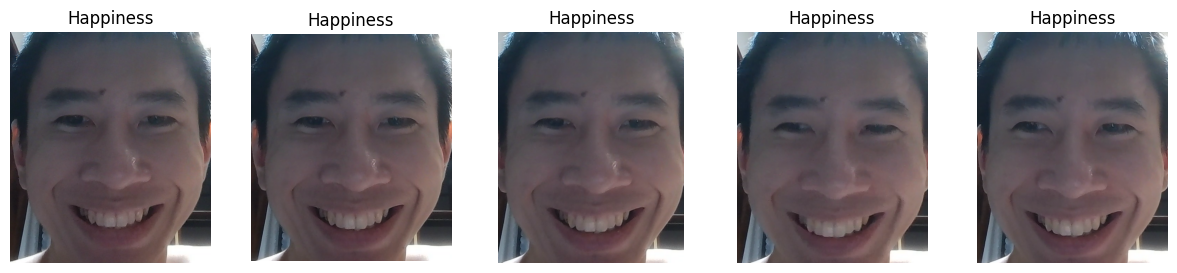

In [5]:
input_file = "C:/Users/ADMIN/Desktop/EmotiEffLib/data/data/video_samples/emotions/Angry/WIN_20250519_22_35_01_Pro.mp4"

fer = EmotiEffLibRecognizer(engine="onnx", model_name=model_name, device=device)

all_frames = []
all_scores = None
# Create a row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
i = 0

cap = cv2.VideoCapture(input_file)
while cap.isOpened():
    success, image = cap.read()
    if not success:
        break
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    facial_images = recognize_faces(image_rgb, device)
    if len(facial_images) == 0:
        continue
    all_frames += facial_images
    emotions, scores = fer.predict_emotions(facial_images, logits=True)
    # Draw each 10th frame
    if i % 10 == 0 and i // 10 < 5:
        idx = i // 10
        axes[idx].imshow(facial_images[0])
        axes[idx].set_title(emotions[0])
        axes[idx].axis('off')
    i += 1
    if all_scores is not None:
        all_scores = np.concatenate((all_scores, scores))
    else:
        all_scores = scores

cap.release()

score = np.mean(all_scores, axis=0)
emotion_idx = np.argmax(score)




### Recognize emotions on a sequence of frames:

In [17]:
_, scores = fer.predict_emotions(all_frames, logits=True)
score = np.mean(scores, axis=0)
emotion_idx = np.argmax(score)

assert fer.idx_to_emotion_class[emotion_idx] == "Anger"

### Recognize emotions on a sequence of frames by calling features extractor and classifier separately

In [18]:
features = fer.extract_features(all_frames)
_, scores = fer.classify_emotions(features, logits=True)
score = np.mean(scores, axis=0)
emotion_idx = np.argmax(score)

assert fer.idx_to_emotion_class[emotion_idx] == "Anger"

## EmotiEffLib with Torch

Install EmotiEffLib with Torch support:

In [ ]:
!pip install emotiefflib[torch]

zsh:1: no matches found: emotiefflib[torch]


Import libraries:

In [ ]:
import os
from typing import List

import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch import MTCNN
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list

Path to the directory with test data, select device and model:

In [ ]:
test_dir = "data"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = get_model_list()[0]

### Read video frame by frame and recognize emotions:

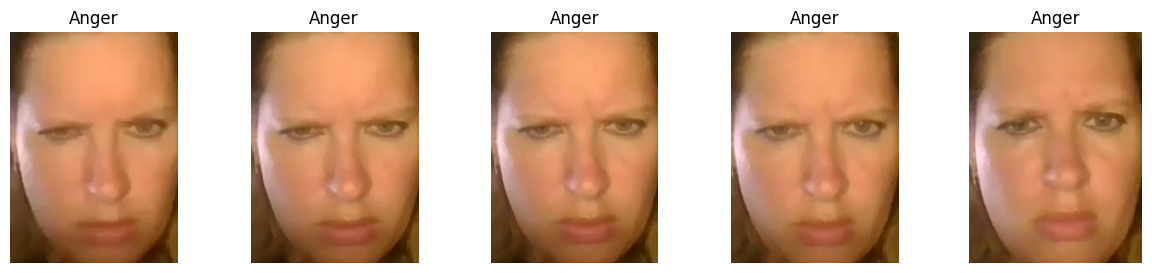

In [ ]:
input_file = os.path.join(test_dir, "video_samples", "emotions", "Angry", "Angry.mp4")
fer = EmotiEffLibRecognizer(engine="onnx", model_name=model_name, device=device)

all_frames = []
all_scores = None
# Create a row of 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
i = 0

cap = cv2.VideoCapture(input_file)
while cap.isOpened():
    success, image = cap.read()
    if not success:
        break

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    facial_images = recognize_faces(image_rgb, device)
    if len(facial_images) == 0:
        continue
    all_frames += facial_images
    emotions, scores = fer.predict_emotions(facial_images, logits=True)
    # Draw each 10th frame
    if i % 10 == 0 and i // 10 < 5:
        idx = i // 10
        axes[idx].imshow(facial_images[0])
        axes[idx].set_title(emotions[0])
        axes[idx].axis('off')
    i += 1
    if all_scores is not None:
        all_scores = np.concatenate((all_scores, scores))
    else:
        all_scores = scores

cap.release()

score = np.mean(all_scores, axis=0)
emotion_idx = np.argmax(score)

assert fer.idx_to_emotion_class[emotion_idx] == "Anger"

### Recognize emotions on a sequence of frames:

In [ ]:
_, scores = fer.predict_emotions(all_frames, logits=True)
score = np.mean(scores, axis=0)
emotion_idx = np.argmax(score)

assert fer.idx_to_emotion_class[emotion_idx] == "Anger"

### Recognize emotions on a sequence of frames by calling features extractor and classifier separately

In [ ]:
features = fer.extract_features(all_frames)
_, scores = fer.classify_emotions(features, logits=True)
score = np.mean(scores, axis=0)
emotion_idx = np.argmax(score)

assert fer.idx_to_emotion_class[emotion_idx] == "Anger"